In [1]:
import torch

dataset = "L008" #marson, sciplex
dimension = 8
threshold = 0.2 #0.3, 0.25

#dict = torch.load("../artifact/saves/grn_dynamic-dropout-20_2022.06.25_18:29:42/model_seed=0_epoch=230.pt")
#dict = torch.load("../artifact/saves/graph-inference-test32_2022.08.08_22:41:35/model_seed=0_epoch=110.pt")
#dict = torch.load("../artifact/saves/graph-inference-sciplex_2022.08.13_00:23:35/model_seed=0_epoch=230.pt")
dict = torch.load("../artifact/saves/graph-inference-L008_2022.09.12_18:55:13/model_seed=0_epoch=230.pt")

/home/ubuntu/anaconda3/envs/gvci-env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
edge_weight = torch.sigmoid(dict[0]["edge_weight_logits"]).cpu().t()
edge_weight

tensor([[0.0774, 0.1634, 0.1577,  ..., 0.1602, 0.1633, 0.1521],
        [0.1706, 0.9998, 0.1416,  ..., 0.1825, 0.1655, 0.1495],
        [0.1405, 0.1637, 0.1033,  ..., 0.1815, 0.1623, 0.1601],
        ...,
        [0.1537, 0.1632, 0.1593,  ..., 0.4458, 0.1741, 0.1605],
        [0.1572, 0.1625, 0.1607,  ..., 0.1684, 0.2276, 0.1635],
        [0.1467, 0.1629, 0.1418,  ..., 0.1618, 0.1605, 0.1738]])

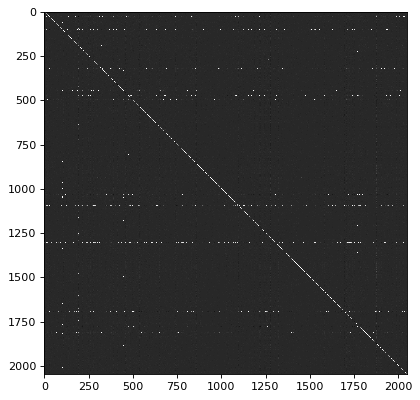

In [3]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

figure(figsize=(8, 6), dpi=80)
plt.imshow(edge_weight, cmap='gray', interpolation='nearest')
plt.show()

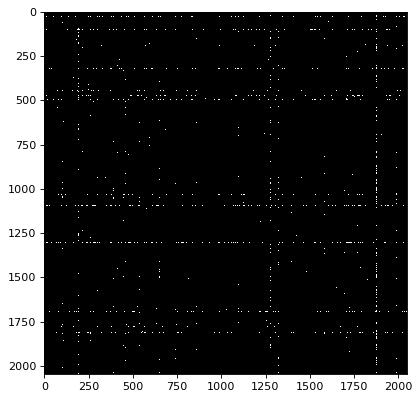

In [4]:
edge_weight_discrete = edge_weight - torch.eye(len(edge_weight))
edge_weight_discrete = edge_weight_discrete.apply_(lambda x: x>threshold)

figure(figsize=(8, 6), dpi=80)
plt.imshow(edge_weight_discrete, cmap='gray', interpolation='nearest')
plt.show()

In [5]:
grn = torch.load("%s_grn_%s.pth" % (dataset, dimension))
grn

Data(x=[2048, 8], edge_index=[2, 37053])

In [6]:
import sys, os
module_paths = [os.path.abspath('.'), os.path.abspath('..')]
for module_path in module_paths:
    if module_path not in sys.path:
        sys.path.append(module_path)
from gvci.utils.graph_utils import to_dense_adj
edge_index = to_dense_adj(grn.edge_index)[0]
edge_index

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

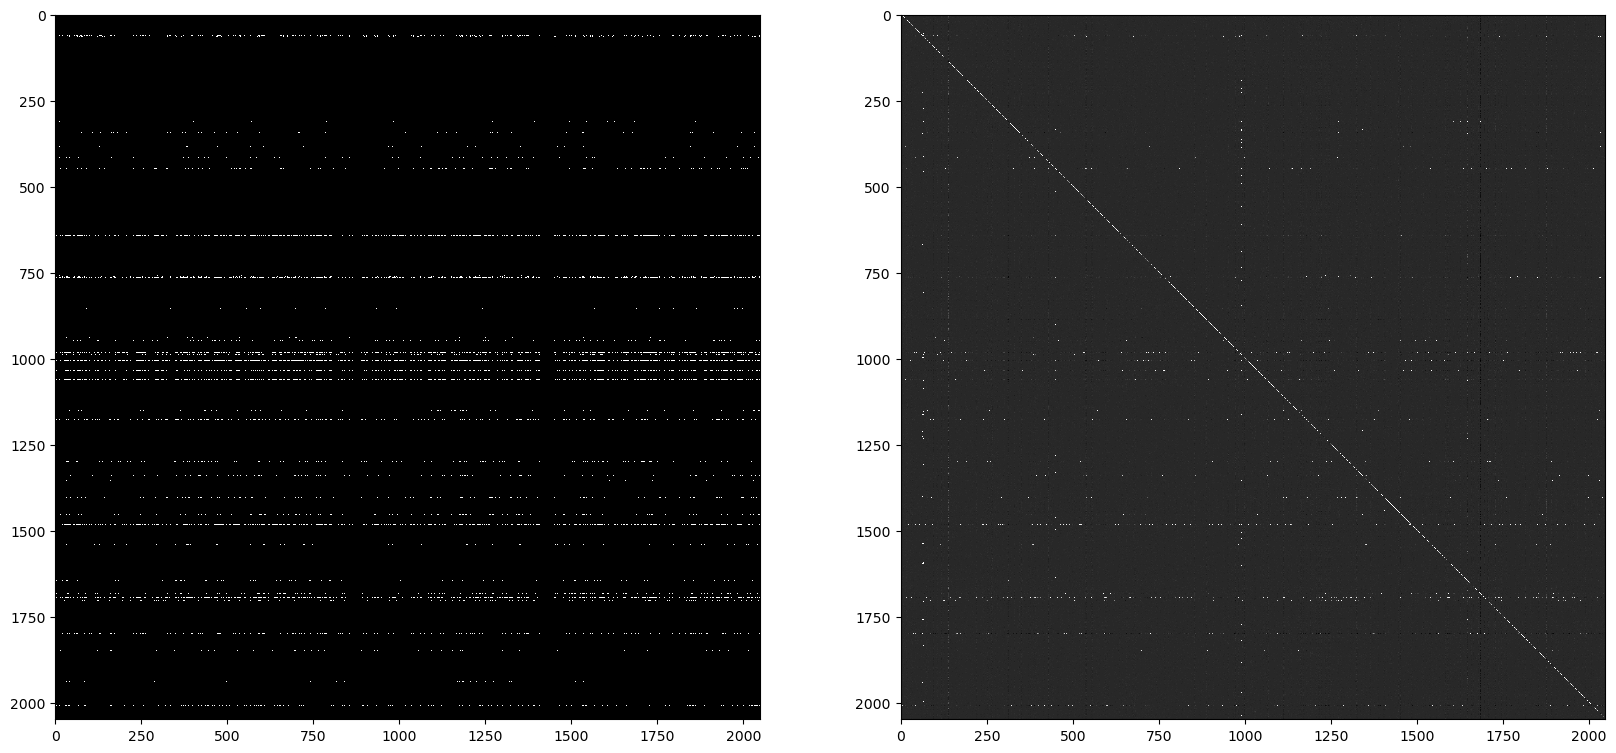

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(20, 10, forward=True)
fig.set_dpi(100)

ax1.imshow(edge_index, cmap='gray', interpolation='nearest')
ax2.imshow(edge_weight, cmap='gray', interpolation='nearest')

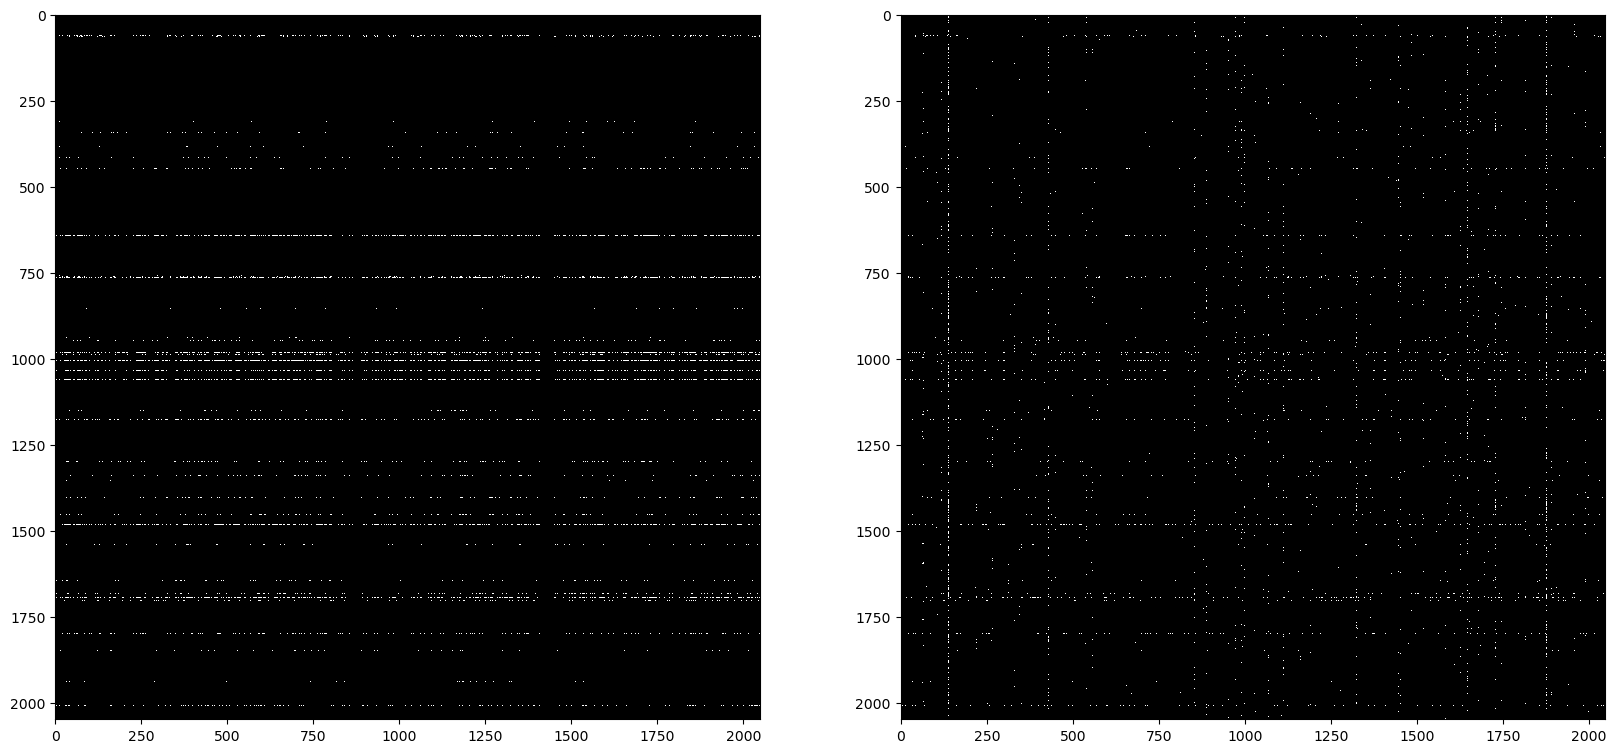

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(20, 10, forward=True)
fig.set_dpi(100)

ax1.imshow(edge_index, cmap='gray', interpolation='nearest')
ax2.imshow(edge_weight_discrete, cmap='gray', interpolation='nearest')

In [9]:
import numpy as np
gene_names = np.genfromtxt('./node/source/%s/genes.txt' % dataset, dtype='str')
gene_names

array(['PERM1', 'AL645608.7', 'TTLL10', ..., 'USP9Y', 'DDX3Y', 'EIF1AY'],
      dtype='<U11')

In [10]:
import pandas as pd
pd.DataFrame(
    data=edge_weight, index=gene_names, columns=gene_names
).to_csv("%s_updated_grn.csv" % dataset, index_label='gene_short_name')

pd.DataFrame(
    data=edge_weight_discrete, index=gene_names, columns=gene_names
).to_csv("%s_updated_grn_filtered.csv" % dataset, index_label='gene_short_name')

In [11]:
import pickle
from gvci.utils.graph_utils import parse_grn
graph_df = pd.read_csv('%s_updated_grn_filtered.csv' % dataset)
nx_graph = parse_grn(graph_df, 'gene_short_name')

pickle.dump(nx_graph, open('./%s_grn.pkl' % dataset, 'wb'))